# Time Series Mixer (TSMixer)
This notebook walks through how to use Darts' `TSMixerModel` and benchmarks it against `TiDEModel`.

TSMixer (Time-series Mixer) is an all-MLP architecture for time series forecasting. 

It does so by integrating historical time series data, future known inputs, and static contextual information. The architecture uses a combination of conditional feature mixing and mixer layers to process and combine these different types of data for effective forecasting.

Translated to Darts, this model supports all types of covariates (past, future, and/or static).

See the original paper and model description [here](https://arxiv.org/abs/2303.06053).

According to the authors, the model outperforms several state-of-the-art models on multivariate forecasting tasks.

Let's see how it performs against `TideModel` on the ETTh1 and ETTh2 datasets.

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from darts.dataprocessing.transformers.scaler import Scaler
from darts.datasets import ETTh1Dataset, ETTh2Dataset
from darts.metrics import mae, mse
from darts.models import TiDEModel, TSMixerModel
from darts.utils.likelihood_models import QuantileRegression

# Data Loading and preparation
We consider the ETTh1 and ETTh2 datasets which contain hourly multivariate data of an electricity transformer (load, oil temperature, ...).
You can find more information [here](https://unit8co.github.io/darts/generated_api/darts.datasets.html#darts.datasets.ETTh1Dataset).

We will add static information to each transformer time series, that identifies whether it is the `ETTh1` or `ETTh2` transformer.
Both TSMixer and TiDE can levarage this information.

In [22]:
series = []
for idx, ds in enumerate([ETTh1Dataset, ETTh2Dataset]):
    trafo = ds().load().astype(np.float32)
    trafo = trafo.with_static_covariates(pd.DataFrame({"transformer_id": [idx]}))
    series.append(trafo)
series[0].pd_dataframe()

component,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...
2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000


Before training, we split the data into train, validation, and test sets. The model will learn from the train set, use the validation set to determine when to stop training, and finally be evaluated on the test set.

In [28]:
train, val, test = [], [], []
for trafo in series:
    train_, temp = trafo.split_after(0.6)
    val_, test_ = temp.split_after(0.5)
    train.append(train_)
    val.append(val_)
    test.append(test_)

Lets look at the splits for the first column "HUFL" for each transformer

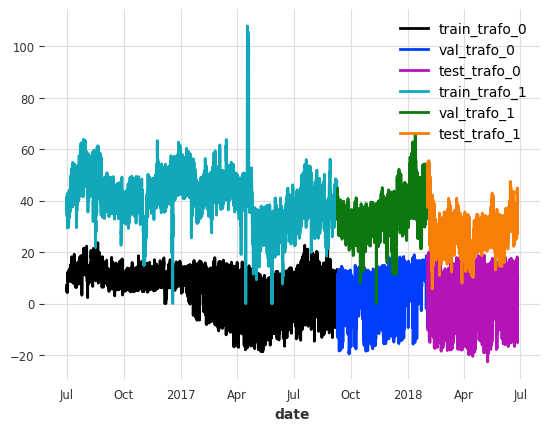

In [31]:
show_col = "HUFL"
for idx, (train_, val_, test_) in enumerate(zip(train, val, test)):
    train_[show_col].plot(label=f"train_trafo_{idx}")
    val_[show_col].plot(label=f"val_trafo_{idx}")
    test_[show_col].plot(label=f"test_trafo_{idx}")

Now let's scale the data. To avoid leaking information from the validation and test sets, we scale the data based on the properties of the train set.

In [32]:
scaler = Scaler()  # default uses sklearn's MinMaxScaler
train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

# Model Parameter Setup
Boilerplate code is no fun, especially in the context of training multiple models to compare performance. To avoid this, we use a common configuration that can be used with any Darts `TorchForecastingModel`.

A few interesting things about these parameters:

- **Gradient clipping:** Mitigates exploding gradients during backpropagation by setting an upper limit on the gradient for a batch.

- **Learning rate:** The majority of the learning done by a model is in the earlier epochs. As training goes on it is often helpful to reduce the learning rate to fine-tune the model. That being said, it can also lead to significant overfitting.

- **Early stopping:** To avoid overfitting, we can use early stopping. It monitors a metric on the validation set and stops training once the metric is not improving anymore based on a custom condition.

- **Likelihood and Loss Functions:** You can either make the model probabilistic with a `likelihood`, or deterministic with a `loss_fn`.

- **Reversible Instance Normalization:** Use [Reversible Instance Normalization](https://openreview.net/forum?id=cGDAkQo1C0p) which in most of the cases improves model performance.

- **Encoders:** We can encode time axis/calendar information and use them as past or future covariates using `add_encoders`. Here, we'll add cyclic encodings of the hour, day of the week, and month as future covariates

In [68]:
def create_params(
    input_chunk_length: int,
    output_chunk_length: int,
    probabilistic_model: bool = False,
    full_training=True,
):
    # early stopping: this setting stops training once the the validation
    # loss has not decreased by more than 1e-5 for 10 epochs
    early_stopper = EarlyStopping(
        monitor="val_loss",
        patience=10,
        min_delta=1e-5,
        mode="min",
    )

    # PyTorch Lightning Trainer arguments (you can add any custom callback)
    if full_training:
        limit_train_batches = None
        limit_val_batches = None
    else:
        limit_train_batches = 20
        limit_val_batches = 10
    pl_trainer_kwargs = {
        "gradient_clip_val": 1,
        "max_epochs": 200,
        "limit_train_batches": limit_train_batches,
        "limit_val_batches": limit_val_batches,
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }

    # optimizer setup, uses Adam by default
    optimizer_cls = torch.optim.Adam
    optimizer_kwargs = {
        "lr": 1e-4,
    }

    # learning rate scheduler
    lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
    lr_scheduler_kwargs = {"gamma": 0.999}

    if probabilistic_model:
        # for probabilistic models, we use quantile regression
        likelihood = QuantileRegression()
        loss_fn = None
    else:
        # for deterministic models (default), we use the MSELoss
        likelihood = None
        loss_fn = torch.nn.MSELoss()

    return {
        "input_chunk_length": input_chunk_length,  # lookback window
        "output_chunk_length": output_chunk_length,  # forecast/lookahead window
        "use_reversible_instance_norm": True,
        "optimizer_kwargs": optimizer_kwargs,
        "pl_trainer_kwargs": pl_trainer_kwargs,
        "lr_scheduler_cls": lr_scheduler_cls,
        "lr_scheduler_kwargs": lr_scheduler_kwargs,
        "likelihood": likelihood,  # use a `likelihood` for probabilistic forecasts
        "loss_fn": loss_fn,  # use a `loss_fn` for determinsitic model
        "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
        "force_reset": True,
        "batch_size": 256,
        "random_state": 42,
        "add_encoders": {
            "cyclic": {
                "future": ["hour", "dayofweek", "month"]
            }  # add cyclic time axis encodings as future covariates
        },
    }

# Model configuration
Let's use the last week of hourly data as lookback window (`input_chunk_length`) and train the model to predict the next 24 hours directly (`output_chunk_length`). Additionally, we tell the model to use the static information. To keep the notebook simple, we'll use a deterministic model and set `full_training=False`. To get even better performance, set `full_training=True`.

Apart from that, we use our helper function to set up all the common model arguments.

In [69]:
input_chunk_length = 7 * 24
output_chunk_length = 24
use_static_covariates = True
probabilistic_model = True
full_training = True

In [70]:
# create the models
model_tsm = TSMixerModel(
    **create_params(
        input_chunk_length,
        output_chunk_length,
        probabilistic_model=probabilistic_model,
        full_training=full_training,
    ),
    use_static_covariates=use_static_covariates,
    model_name="tsm",
)
model_tide = TiDEModel(
    **create_params(
        input_chunk_length,
        output_chunk_length,
        probabilistic_model=probabilistic_model,
        full_training=full_training,
    ),
    use_static_covariates=use_static_covariates,
    model_name="tide",
)
models = {
    "TSM": model_tsm,
    "TiDE": model_tide,
}

Now let's train all of the models. When using early stopping it is important to save checkpoints. This allows us to continue past the best model configuration and then restore the optimal weights once training has been completed.

In [71]:
# train the models and load the model from its best state/checkpoint
for name, model in models.items():
    model.fit(
        series=train,
        val_series=val,
        verbose=True,
    )
    # load from checkpoint returns a new model object, we store it in the models dict
    models[name] = model.load_from_checkpoint(model_name=model.model_name, best=True)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [75]:
# set the number of prediction samples
num_samples = 1 if not probabilistic_model else 500

hfc = model.historical_forecasts(
    series=test,
    forecast_horizon=output_chunk_length,
    stride=output_chunk_length,
    last_points_only=False,
    retrain=False,
    num_samples=num_samples,
    verbose=True,
)

Predicting: |          | 0/? [00:00<?, ?it/s]

In [79]:
hfc = scaler.inverse_transform(hfc)

In [84]:
model.backtest(series=series, historical_forecasts=hfc, metric=[mae, mse])

[array([1.58988456, 8.73799483]), array([1.86582919, 8.42429788])]

In [80]:
len(hfc[0])

138

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

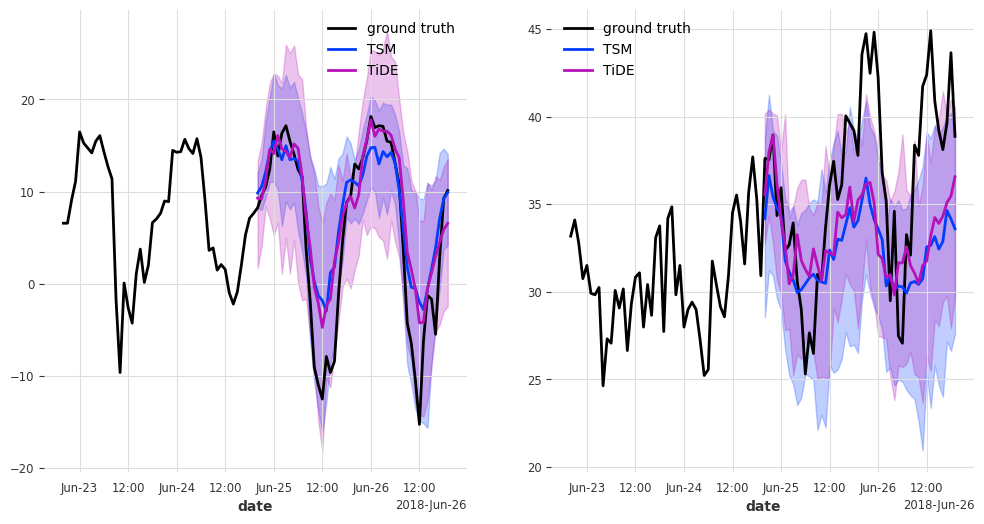

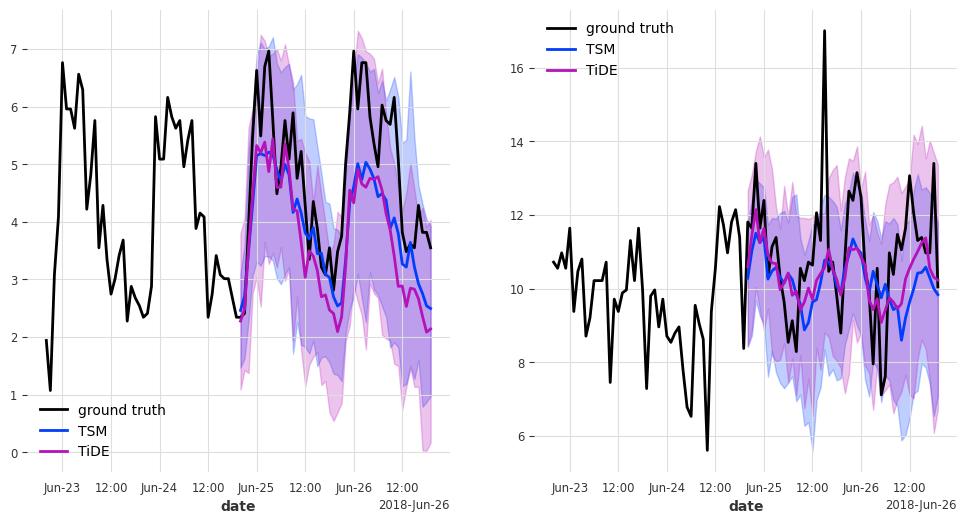

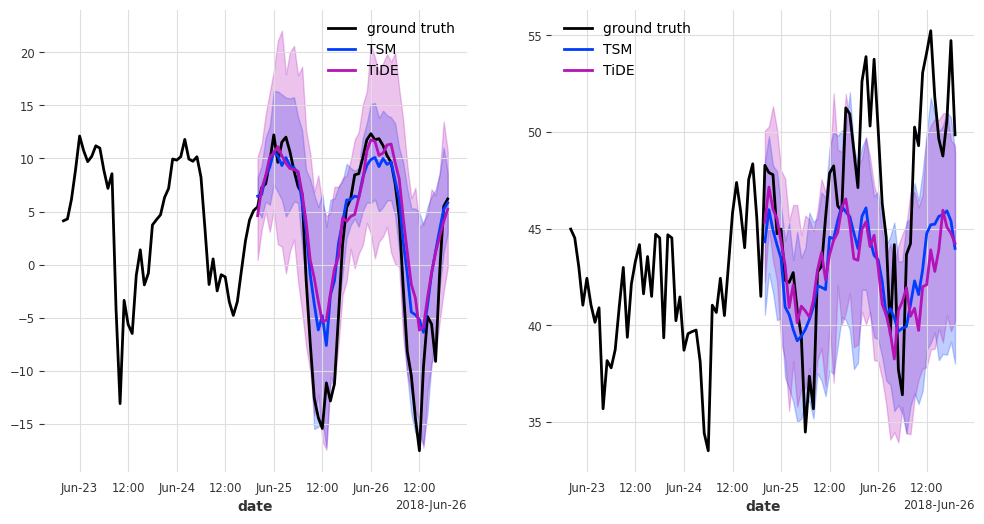

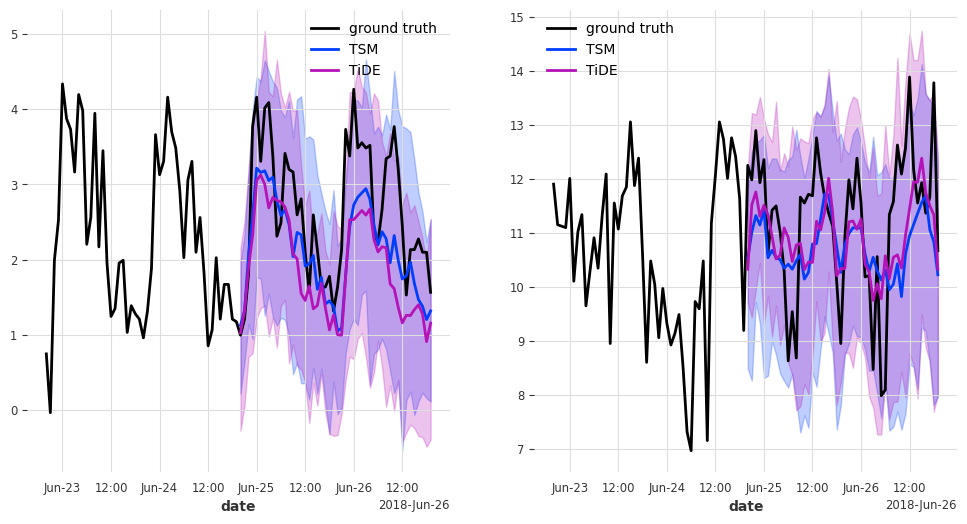

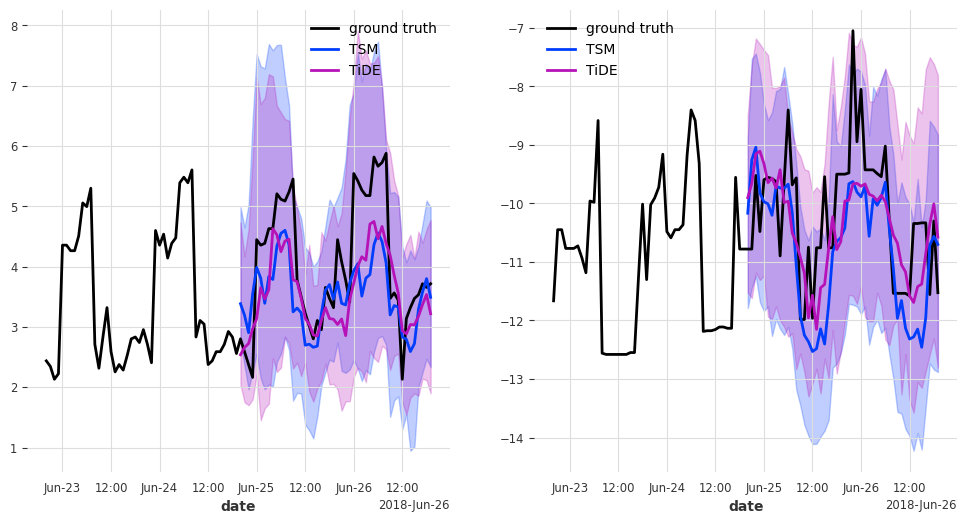

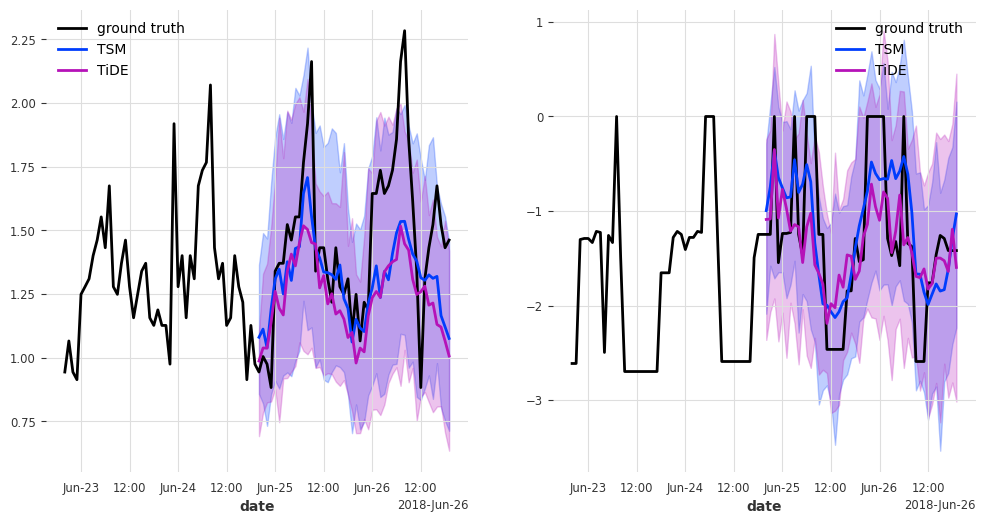

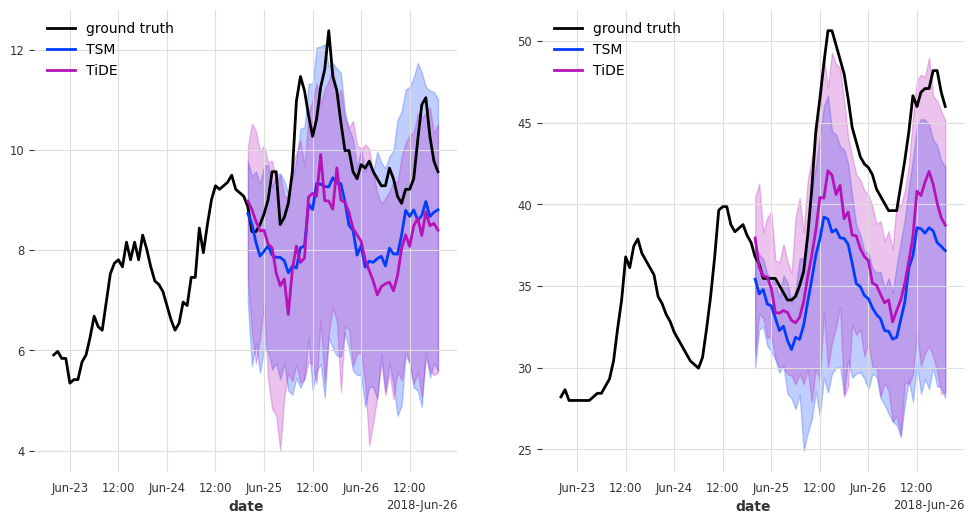

In [72]:
# set the number of prediction samples
num_samples = 1 if not probabilistic_model else 500

# we will predict the next `pred_steps` points after the end of `pred_input`
pred_steps = output_chunk_length * 2
pred_input = [trafo[:-pred_steps] for trafo in test]

preds = {}
result_accumulator = {}
test_ = scaler.inverse_transform(test)
# predict with each model and compute/store the metrics against the test sets
for model_name, model in models.items():
    preds[model_name] = scaler.inverse_transform(
        model.predict(n=pred_steps, series=pred_input, num_samples=num_samples)
    )
    result_accumulator[model_name] = {
        "mae": mae(test_, preds[model_name]),
        "mse": mse(test_, preds[model_name]),
    }

for col in test_[0].columns:
    fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
    for trafo_idx, trafo in enumerate(test_):
        trafo[col][-2 * pred_steps :].plot(label="ground truth", ax=axes[trafo_idx])
        for model_name, pred_series in preds.items():
            pred_series[trafo_idx][col].plot(label=model_name, ax=axes[trafo_idx])
    plt.show()

# Results
In this case, vanilla TiDE is similarly accurate as NHiTs. Including reversible instance normalization (`RINorm`) drastically helped to improve the TiDE forecasts (Keep in mind that this is just an example, and it is not always guaranteed to improve performance).

In [73]:
result_accumulator

{'TSM': {'mae': [1.5882425447925927, 2.8141418772173066],
  'mse': [7.836278022000398, 17.351782942276024]},
 'TiDE': {'mae': [1.6942351494161854, 2.497296320318821],
  'mse': [8.416018831790225, 14.270377987199023]}}

In [53]:
results_df = pd.DataFrame.from_dict(result_accumulator, orient="index")
results_df.plot.bar()
results_df

TypeError: no numeric data to plot